In [38]:
import episimlab.models.toy
import episimlab.apply_counts_delta
import xarray as xr
import xsimlab as xs
import matplotlib.pyplot as plt

# 20201116

The goal of this notebook is to try out visualization workflows in `episimlab`. The workflow I'm testing here is importing one of the pre-defined models, adding a custom process that ingests the `apply_counts_delta__counts` variable, and have that process generate a graph.

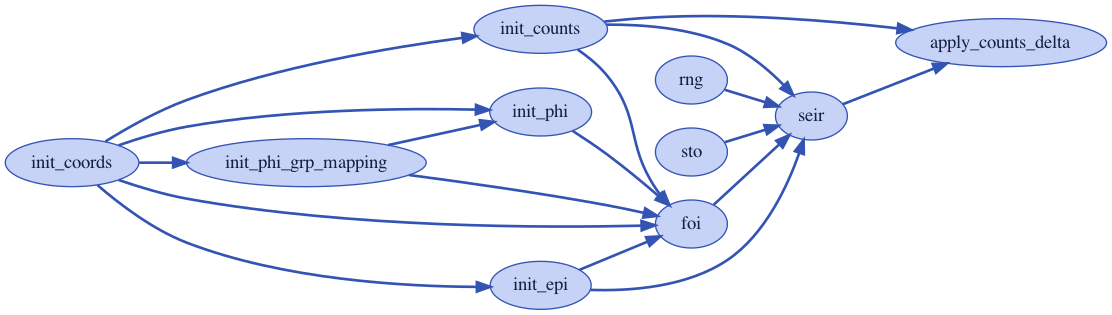

In [14]:
model = episimlab.models.toy.cy_seir_cy_foi()
model.visualize()

### Define a new process that carries generates graph

In [15]:
@xs.process
class BasicTimeSeries:
    
    counts = xs.foreign(
        episimlab.apply_counts_delta.ApplyCountsDelta,
        'counts',
        intent='in'
    )
    
    def finalize(self):
        assert isinstance(self.counts, xr.DataArray)
        self.xr_viz(self.counts)
        
    def xr_viz(self, data_array, sel=dict(),
               timeslice=slice(0, None),
               sum_over=['risk_group', 'age_group', 'vertex']):
        """Uses DataArray.plot, which builds on mpl
        """
        isel = {'time': timeslice}
        da = data_array[isel].loc[sel].sum(dim=sum_over)
        _ = da.plot.line(x='time', aspect=2, size=7)

### Add this new process to the pre-packaged model

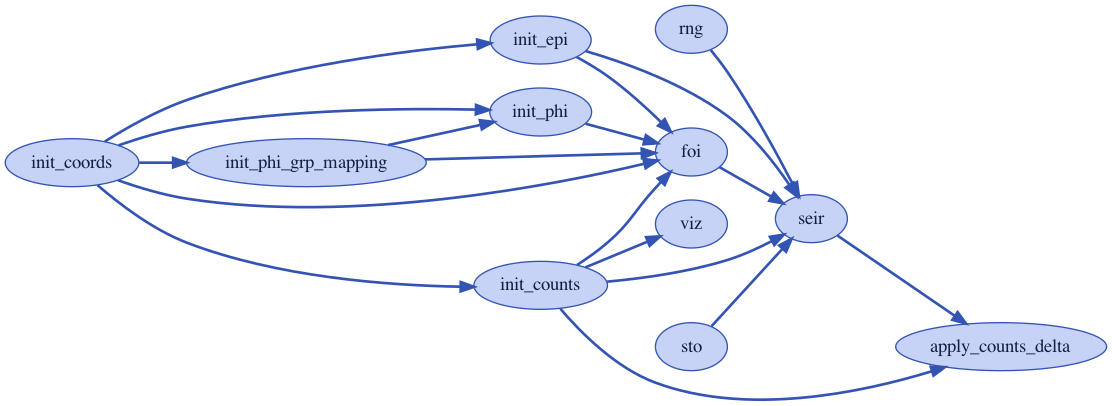

In [17]:
with_viz = model.update_processes(dict(viz=BasicTimeSeries))
with_viz.visualize()

### This won't work

I realized that to plot a time series, MPL needs access to the time axis. This does not appear to be doable (or at least, it isn't straighforward) in the `xsimlab` framework.

It really seems as if the final data product of every `episimlab` run is `apply_counts_delta__counts`, and any post-processing should be handled outside of the package.

For the sake of demonstration, I'll try doing that now, but this is functionality that belongs in a different package IMO.

In [54]:
output_vars = {
    'apply_counts_delta__counts': 'step',
    'foi__foi': 'step'
}
input_vars = {
    'rng__seed_entropy': 12345,
    'sto__sto_toggle': 1e8
}



input_ds = xs.create_setup(
    model=model,
    clocks=dict(step=range(700)),
    input_vars=input_vars,
    output_vars=output_vars
)
result = input_ds.xsimlab.run(model=model)
result

<xarray.Dataset>
Dimensions:                     (age_group: 5, compartment: 16, day_of_week: 7, phi_grp1: 10, phi_grp2: 10, risk_group: 2, step: 700, vertex: 3)
Coordinates:
  * age_group                   (age_group) <U5 '0-4' '5-17' ... '50-64' '65+'
  * compartment                 (compartment) <U5 'S' 'E' 'Pa' ... 'Iy2Ih' 'H2D'
  * day_of_week                 (day_of_week) int64 0 1 2 3 4 5 6
  * phi_grp1                    (phi_grp1) int64 1 0 5 4 3 2 7 6 9 8
  * phi_grp2                    (phi_grp2) int64 1 0 5 4 3 2 7 6 9 8
  * risk_group                  (risk_group) <U4 'low' 'high'
  * step                        (step) int64 0 1 2 3 4 5 ... 695 696 697 698 699
  * vertex                      (vertex) int64 0 1 2
Data variables:
    apply_counts_delta__counts  (step, vertex, age_group, risk_group, compartment) float64 ...
    foi__foi                    (step, vertex, age_group, risk_group) float64 ...
    rng__seed_entropy           int64 12345
    sto__sto_toggle             float64 1e+08

...and write to a zarr archive

In [55]:
!rm -rf ../data/20201116_try_viz.zarr
result.to_zarr('../data/20201116_try_viz.zarr')

## Plot using MPL

In [78]:
def xr_viz(data_array, sel=dict(), isel=dict(),
           timeslice=slice(0, 100),
           sum_over=['risk_group', 'age_group']):
    """Uses DataArray.plot, which builds on mpl
    """
    assert isinstance(data_array, xr.DataArray)
    isel.update({'step': timeslice})
    da = data_array[isel].loc[sel].sum(dim=sum_over)
    _ = da.plot.line(x='step', aspect=2, size=7)

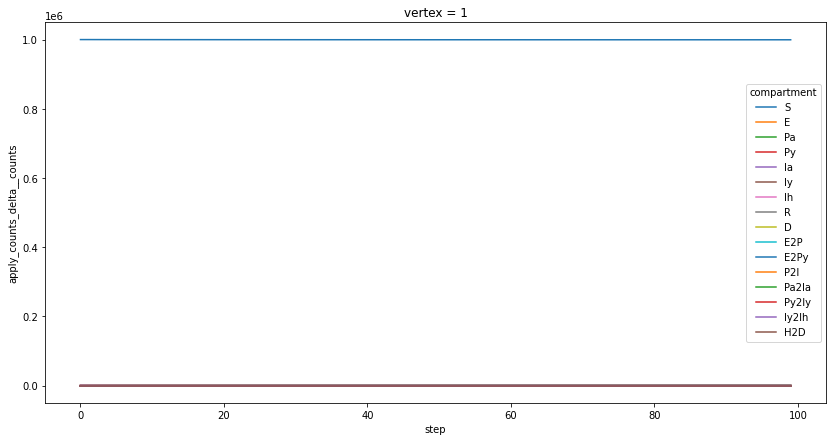

In [79]:
xr_viz(result['apply_counts_delta__counts'], sel=dict(vertex=1))

Looks like no one is getting infected; let's look at the FOI...

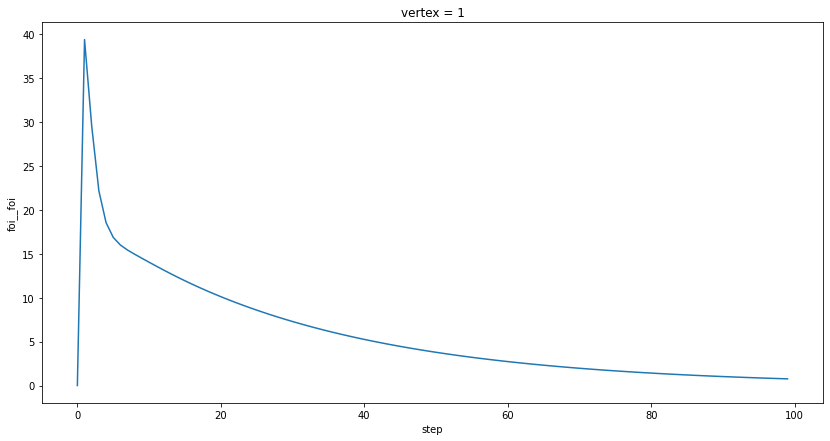

In [80]:
xr_viz(result['foi__foi'], sel=dict(vertex=1))

In [74]:
result['foi__foi'].sum(['age_group', 'risk_group', 'vertex'])
# .loc[dict(vertex=1)]

<xarray.DataArray 'foi__foi' (step: 700)>
array([0.00000000e+00, 3.93553227e+01, 2.95164920e+01, 2.21364978e+01,
       1.85327665e+01, 1.68523708e+01, 1.59802562e+01, 1.54067462e+01,
       1.49278517e+01, 1.44733464e+01, 1.40250526e+01, 1.35819647e+01,
       1.31470001e+01, 1.27228062e+01, 1.23109262e+01, 1.19119800e+01,
       1.15260128e+01, 1.11527692e+01, 1.07918611e+01, 1.04428570e+01,
       1.01053242e+01, 9.77884597e+00, 9.46302627e+00, 9.15749003e+00,
       8.86188142e+00, 8.57586185e+00, 8.29910810e+00, 8.03131078e+00,
       7.77217307e+00, 7.52140967e+00, 7.27874600e+00, 7.04391744e+00,
       6.81666879e+00, 6.59675373e+00, 6.38393437e+00, 6.17798089e+00,
       5.97867114e+00, 5.78579036e+00, 5.59913087e+00, 5.41849181e+00,
       5.24367889e+00, 5.07450412e+00, 4.91078566e+00, 4.75234753e+00,
       4.59901947e+00, 4.45063670e+00, 4.30703980e+00, 4.16807447e+00,
       4.03359138e+00, 3.90344605e+00, 3.77749862e+00, 3.65561376e+00,
       3.53766049e+00, 3.42351207e+00, 3.31304582e+00, 3.20614303e+00,
       3.10268879e+00, 3.00257193e+00, 2.90568482e+00, 2.81192333e+00,
       2.72118666e+00, 2.63337729e+00, 2.54840080e+00, 2.46616585e+00,
       2.38658402e+00, 2.30956976e+00, 2.23504024e+00, 2.16291534e+00,
       2.09311750e+00, 2.02557167e+00, 1.96020521e+00, 1.89694783e+00,
       1.83573150e+00, 1.77649037e+00, 1.71916075e+00, 1.66368096e+00,
       1.60999135e+00, 1.55803415e+00, 1.50775348e+00, 1.45909527e+00,
...
       2.85565469e-08, 2.76348558e-08, 2.67429132e-08, 2.58797590e-08,
       2.50444639e-08, 2.42361288e-08, 2.34538836e-08, 2.26968861e-08,
       2.19643214e-08, 2.12554010e-08, 2.05693617e-08, 1.99054650e-08,
       1.92629962e-08, 1.86412638e-08, 1.80395984e-08, 1.74573523e-08,
       1.68938988e-08, 1.63486314e-08, 1.58209629e-08, 1.53103256e-08,
       1.48161695e-08, 1.43379628e-08, 1.38751908e-08, 1.34273551e-08,
       1.29939738e-08, 1.25745803e-08, 1.21687232e-08, 1.17759655e-08,
       1.13958844e-08, 1.10280709e-08, 1.06721289e-08, 1.03276753e-08,
       9.99433923e-09, 9.67176195e-09, 9.35959617e-09, 9.05750586e-09,
       8.76516581e-09, 8.48226132e-09, 8.20848787e-09, 7.94355072e-09,
       7.68716469e-09, 7.43905377e-09, 7.19895088e-09, 6.96659754e-09,
       6.74174365e-09, 6.52414714e-09, 6.31357377e-09, 6.10979687e-09,
       5.91259707e-09, 5.72176210e-09, 5.53708651e-09, 5.35837151e-09,
       5.18542472e-09, 5.01805996e-09, 4.85609706e-09, 4.69936167e-09,
       4.54768508e-09, 4.40090400e-09, 4.25886043e-09, 4.12140146e-09,
       3.98837911e-09, 3.85965019e-09, 3.73507612e-09, 3.61452281e-09,
       3.49786047e-09, 3.38496353e-09, 3.27571045e-09, 3.16998363e-09,
       3.06766924e-09, 2.96865715e-09, 2.87284077e-09, 2.78011697e-09,
       2.69038592e-09, 2.60355102e-09, 2.51951881e-09, 2.43819883e-09,
       2.35950352e-09, 2.28334819e-09, 2.20965085e-09, 2.13833216e-09])
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 ... 692 693 694 695 696 697 698 699

FOI is spiking as expected, but the values for FOI are quite small. Helpfully, this indicates that I should probably run at least 50 time points in pytests.

Let's see if the infected individuals spiked as expected as well...

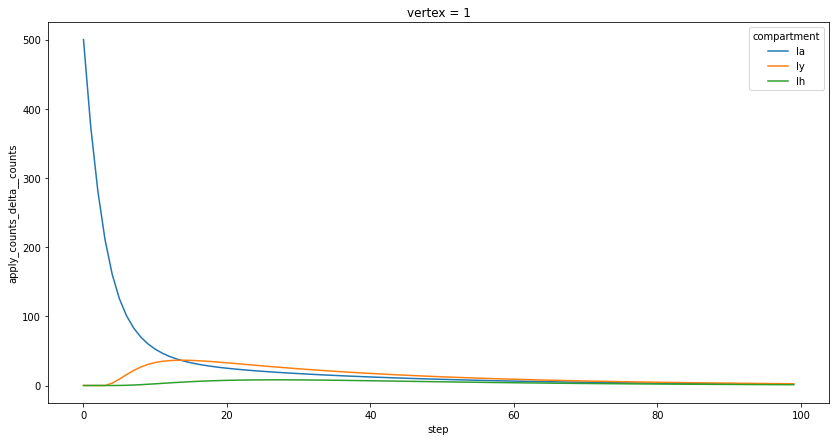

In [81]:
xr_viz(
    result['apply_counts_delta__counts'],
    sel=dict(vertex=1, compartment=['Ia', 'Iy', 'Ih']),
    timeslice=slice(None, 100)
)

In [70]:
result['apply_counts_delta__counts'].loc[dict(vertex=1, compartment=['Ia'])].sum(['age_group', 'risk_group'])

<xarray.DataArray 'apply_counts_delta__counts' (step: 700, compartment: 1)>
array([[5.00000000e+02],
       [3.75000000e+02],
       [2.81250000e+02],
       [2.10937500e+02],
       [1.60740275e+02],
       [1.25554380e+02],
       [1.00754273e+02],
       [8.29497252e+01],
       [6.98702975e+01],
       [6.00442715e+01],
       [5.25162376e+01],
       [4.66519830e+01],
       [4.20168668e+01],
       [3.83033014e+01],
       [3.52877885e+01],
       [3.28048585e+01],
       [3.07305457e+01],
       [2.89713435e+01],
       [2.74564625e+01],
       [2.61322053e+01],
...
       [9.38724232e-09],
       [9.08425969e-09],
       [8.79105614e-09],
       [8.50731602e-09],
       [8.23273389e-09],
       [7.96701418e-09],
       [7.70987084e-09],
       [7.46102706e-09],
       [7.22021496e-09],
       [6.98717531e-09],
       [6.76165725e-09],
       [6.54341800e-09],
       [6.33222265e-09],
       [6.12784384e-09],
       [5.93006156e-09],
       [5.73866290e-09],
       [5.55344182e-09],
       [5.37419894e-09],
       [5.20074130e-09],
       [5.03288218e-09]])
Coordinates:
  * compartment  (compartment) <U5 'Ia'
  * step         (step) int64 0 1 2 3 4 5 6 7 ... 693 694 695 696 697 698 699
    vertex       int64 1